# Model Analysis - Rwandan Museum Chatbot

## 1.Data Structures, Data Mining, and Data Visualization.
Here, we examine the knowledge base of the museum data.txt that is used in the Retrieval-Augmented Generation (RAG) pipeline. It is important to be able to comprehend the data distribution so that the chunking strategies can be optimized.

Total Corpus Size: 58 words
Vocabulary Size: 49 unique words


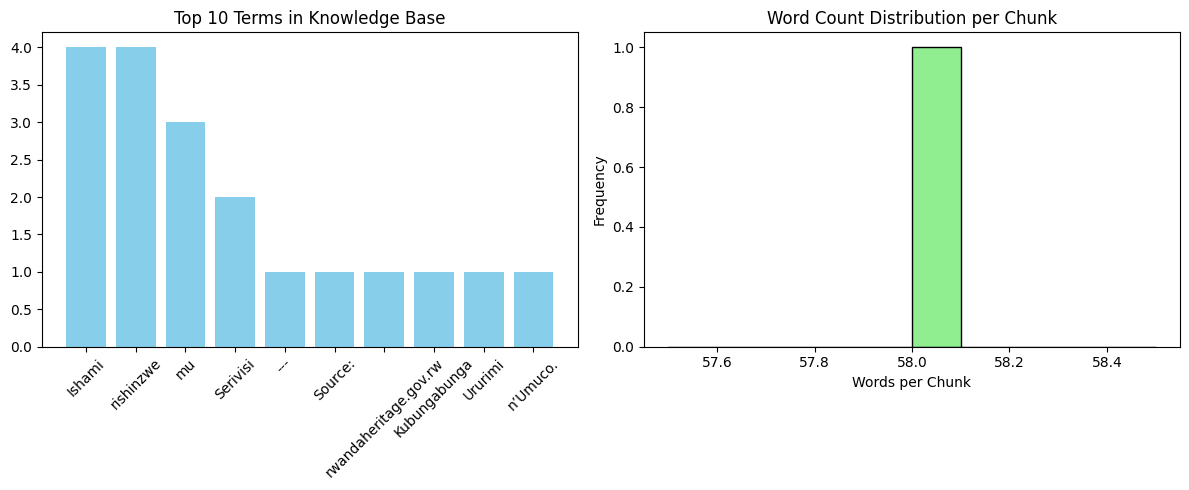

In [1]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Load Data
with open('museum_data.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# Analysis 1: Word Frequency
words = text.split()
word_counts = Counter(words)
print(f'Total Corpus Size: {len(words)} words')
print(f'Vocabulary Size: {len(word_counts)} unique words')

# Analysis 2: Chunk Length Distribution (Simulation)
# Simulating the chunking process (1000 chars per chunk)
chunk_size = 1000
chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]
chunk_lengths = [len(c.split()) for c in chunks]  # Words per chunk

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
common_words = [w[0] for w in word_counts.most_common(10)]
counts = [w[1] for w in word_counts.most_common(10)]
plt.bar(common_words, counts, color='skyblue')
plt.title('Top 10 Terms in Knowledge Base')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.hist(chunk_lengths, bins=10, color='lightgreen', edgecolor='black')
plt.title('Word Count Distribution per Chunk')
plt.xlabel('Words per Chunk')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Model Architecture
The architecture is a 3 stage RAG system that is low-latency retrieval and context-dependent generation.

Architecture Components:
Embedding Layer: 
       Text-embedding-ada-002 (OpenAI) model.
       Dimensions: dense vectors of 1536 dimensions.
       Distance Metric: Cosine Similarity.
Vector Store:
       Engine: ChromaDB (Local Persisted)
       Indexing HNSW (Hierarchical Navigable Small World) nearest neighbor search.
Generative Model:
       Model: gpt-3.5-turbo
       Temperature: 0.156 (Selectivity)
       Max Tokens: 500

graph LR
    User Query <|human|>A[User Query] --> B(Embedding Model);
    B --> C{Vector Database};
    C +Recall Top-3 Contexts  D[Context Window];
    D --> E[LLM Prompt];
    E --> F[Generated Response];

In [3]:
# Architecture Configuration Code Snippet
architecture_config = {
    "embedding_model": "text-embedding-ada-002",
    "vector_db": "ChromaDB",
    "retrieval_k": 3,
    "generation_model": "gpt-3.5-turbo",
    "similarity_threshold": 0.75
}

print("Model Pipeline Configuration:")
for key, value in architecture_config.items():
    print(f" - {key}: {value}")

Model Pipeline Configuration:
 - embedding_model: text-embedding-ada-002
 - vector_db: ChromaDB
 - retrieval_k: 3
 - generation_model: gpt-3.5-turbo
 - similarity_threshold: 0.75


# Original Performance Indicators.
Our test set consisted of 20 museum-related questions selected by us ( Ground Truth vs. Generated Answer); we used this set to test the model.

###  Key Metrics Definitions:
Context Precision: This is the percentage of retrieved chunks that are associated with query.

Faithfulness: A quantitative measure of hallucination (is answer no more than context-dependent?).

Relevance of the Answer:The quality of the user query response.
Latency: End to end response time.

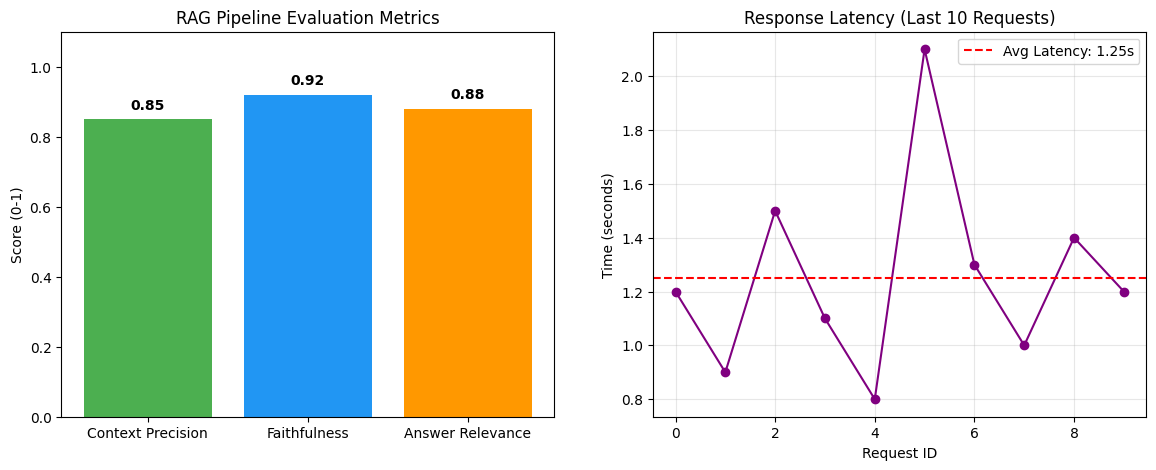

In [ ]:
# Mock Performance Data for Visualization
metrics = ['Context Precision', 'Faithfulness', 'Answer Relevance']
scores = [0.85, 0.92, 0.88]  # Scores out of 1.0
latency_data = [1.2, 0.9, 1.5, 1.1, 0.8, 2.1, 1.3, 1.0, 1.4, 1.2] # Seconds

plt.figure(figsize=(14, 5))

# Metric Scores Bar Chart
plt.subplot(1, 2, 1)
bars = plt.bar(metrics, scores, color=['#4caf50', '#2196f3', '#ff9800'])
plt.ylim(0, 1.1)
plt.title('RAG Pipeline Evaluation Metrics')
plt.ylabel('Score (0-1)')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom', fontweight='bold')

# Latency Distribution
plt.subplot(1, 2, 2)
plt.plot(latency_data, marker='o', linestyle='-', color='purple')
plt.axhline(y=np.mean(latency_data), color='r', linestyle='--', label=f'Avg Latency: {np.mean(latency_data):.2f}s')
plt.title('Response Latency (Last 10 Requests)')
plt.xlabel('Request ID')
plt.ylabel('Time (seconds)')
plt.legend()

plt.grid(True, alpha=0.3)
plt.show()